Import the libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
import torch
import torch.nn as nn

In [4]:
# Initialize and train the BERT sentiment classification model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Load dataset

In [5]:
data_file = "topical_chat.csv"

In [6]:
data = pd.read_csv(data_file)

In [7]:
data.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpful...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


Looking at the sample messages above , sentiment is labelled for individual messages independent of their context within conversations, then the 'conversation_id' field may not be necessary. So, we can drop 'conversation_id' column

In [8]:
# Drop the 'conversation_id' column
data.drop(columns=["conversation_id"], inplace=True)

# Print the updated DataFrame
print(data.head())

                                             message               sentiment
0              Are you a fan of Google or Microsoft?  Curious to dive deeper
1  Both are excellent technology they are helpful...  Curious to dive deeper
2   I'm not  a huge fan of Google, but I use it a...  Curious to dive deeper
3   Google provides online related services and p...  Curious to dive deeper
4   Yeah, their services are good. I'm just not a...  Curious to dive deeper


In [9]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()
print(missing_values)

message      5
sentiment    0
dtype: int64


In [10]:
# Drop rows with missing values in the 'message' column
data = data.dropna(subset=["message"])

In [11]:
missing_values = data.isnull().sum()
print(missing_values)

message      0
sentiment    0
dtype: int64


In [12]:
# Count the occurrences of each class label
class_distribution = data["sentiment"].value_counts()

print("Class Distribution:")
print(class_distribution)

Class Distribution:
sentiment
Curious to dive deeper    80887
Neutral                   41367
Surprised                 30637
Happy                     29615
Sad                        2533
Disgusted                  1432
Fearful                    1026
Angry                       876
Name: count, dtype: int64


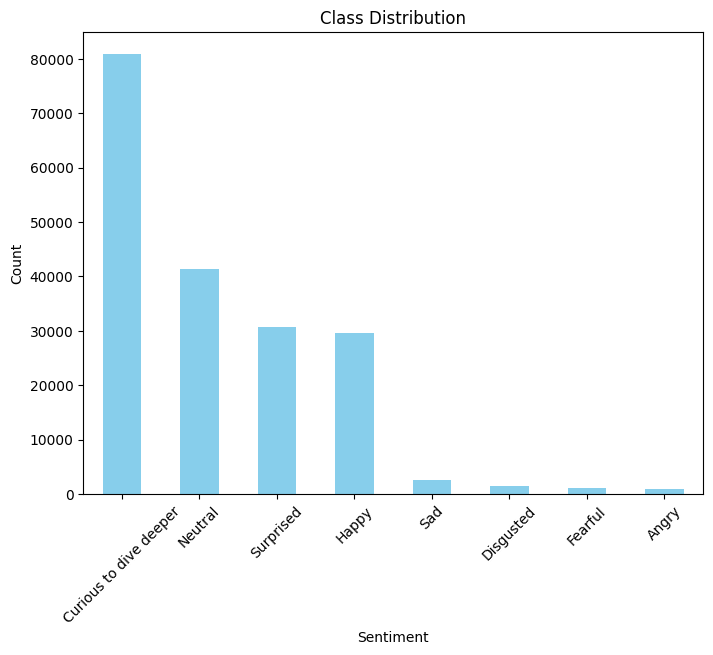

In [13]:
import matplotlib.pyplot as plt

# Plot the class distribution
plt.figure(figsize=(8, 6))
class_distribution.plot(kind="bar", color="skyblue")
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Get unique values in the 'sentiment' column to define sentiment classes

In [14]:
# Get unique values in the 'sentiment' column
unique_sentiments = data["sentiment"].unique()

In [15]:
# Create sentiment mapping dictionary
sentiment_mapping = {sentiment: idx for idx, sentiment in enumerate(unique_sentiments)}

print("Sentiment Mapping Dictionary:")
print(sentiment_mapping)

Sentiment Mapping Dictionary:
{'Curious to dive deeper': 0, 'Happy': 1, 'Neutral': 2, 'Surprised': 3, 'Disgusted': 4, 'Sad': 5, 'Fearful': 6, 'Angry': 7}


Data Preprocessing

1. Converts text to lowercase.
2. Removes special characters, numbers, and punctuation.
3. Tokenizes the text into words.
4. Removes stopwords using NLTK's English stop words list.
5. Lemmatizes the words to their base form using NLTK's WordNet lemmatizer.

Import NLTK toolkit libraries 

In [16]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     /home/vanitha.alagarsamy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vanitha.alagarsamy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/vanitha.alagarsamy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters, numbers, and punctuation
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    preprocessed_text = " ".join(tokens)

    return preprocessed_text

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188373 entries, 0 to 188377
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   message    188373 non-null  object
 1   sentiment  188373 non-null  object
dtypes: object(2)
memory usage: 4.3+ MB


In [19]:
# preprocessing the messages
data["preprocessed_message"] = data["message"].apply(preprocess_text)

Convert labels to numerical values

In [20]:
# Convert labels to numerical values
data["sentiment"] = data["sentiment"].map(sentiment_mapping)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [22]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data["preprocessed_message"], data["sentiment"], test_size=0.2, random_state=42
)

In [23]:
from transformers import BertTokenizer, BertModel, BertConfig, AdamW

/home/vanitha.alagarsamy/miniconda3/envs/langchain_test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [25]:
# Tokenize input text
def tokenize_text(text):
    # Use batch_encode_plus to tokenize and pad sequences
    inputs = tokenizer.batch_encode_plus(
        text, padding=True, truncation=True, return_tensors="pt"
    )
    return inputs

In [26]:
# Create custom PyTorch dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [27]:
# Define maximum sequence length
MAX_LEN = 128

# Convert dataset to PyTorch DataLoader
train_dataset = CustomDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [28]:
# Define BERT sentiment classification model
class BERTSentimentClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(768, num_classes)  # BERT-base hidden size is 768

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids, attention_mask=attention_mask
        ).last_hidden_state.mean(
            dim=1
        )  # Pooling strategy: mean of token embeddings
        outputs = self.dropout(outputs)
        outputs = self.fc(outputs)
        return outputs

In [29]:
# Initialize and train the BERT sentiment classification model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BERTSentimentClassifier(num_classes=len(sentiment_mapping)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

cuda


/home/vanitha.alagarsamy/miniconda3/envs/langchain_test/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
# Training loop
for epoch in range(3):  # Train for 3 epochs (adjust as needed)
    running_loss = 0.0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader)}")

Epoch 1 Loss: 1.2693383498556294
Epoch 2 Loss: 1.0968913246112264
Epoch 3 Loss: 0.7245634431925043


In [35]:
from sklearn.metrics import accuracy_score

Train Accuracy

In [36]:
# Initialize lists to store true labels and predicted labels
train_true_labels = []
train_predictions = []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    # Iterate over the training data
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].tolist()
        train_true_labels.extend(labels)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, 1)
        train_predictions.extend(preds.cpu().numpy())

# Calculate training accuracy
train_accuracy = accuracy_score(train_true_labels, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.8901


Evaluate the trained model & Test Accuracy

In [31]:
# Evaluate the trained model
model.eval()
# Convert dataset to PyTorch DataLoader
test_dataset = CustomDataset(X_test.tolist(), y_test.tolist(),tokenizer, MAX_LEN)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
predictions = []
true_labels = []

for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].tolist()
    true_labels.extend(labels)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()  # Move the tensor to CPU and convert to numpy array
        predictions.extend(preds)

In [33]:
# Generate classification report
print(
    classification_report(
        true_labels, predictions, target_names=sentiment_mapping.keys()
    )
)

                        precision    recall  f1-score   support

Curious to dive deeper       0.57      0.62      0.59     16097
                 Happy       0.39      0.30      0.34      5942
               Neutral       0.39      0.49      0.43      8294
             Surprised       0.40      0.31      0.35      6157
             Disgusted       0.16      0.09      0.12       302
                   Sad       0.30      0.17      0.22       522
               Fearful       0.20      0.16      0.18       207
                 Angry       1.00      0.01      0.01       154

              accuracy                           0.47     37675
             macro avg       0.43      0.27      0.28     37675
          weighted avg       0.47      0.47      0.46     37675



In [34]:

# Convert true labels and predicted labels to numpy arrays
true_labels_np = np.array(true_labels)
predictions_np = np.array(predictions)

# Calculate accuracy
accuracy = accuracy_score(true_labels_np, predictions_np)

print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.4715


Findings:
A model accuracy of 47% suggests that the model is performing slightly better than random guessing (which would have an accuracy of 12.5% for 8 classes). Here are some possible reasons why the accuracy might be low:

1. Complexity of Sentiment Analysis
2. Imbalance in Data Distribution
3. Tokenization and Padding
4. Hyperparameter Tuning
5. External Factors: External factors such as noise in the data, ambiguous labels, or inherent subjectivity in sentiment annotations

Improvements:
1. Fine-tuning BERT: BERT models can be fine-tuned on domain-specific data to improve performance. We  can try training BERT with different learning rates, batch sizes, or number of epochs to find the optimal hyperparameters.

2. Use Larger Pre-trained Models: Instead of bert-base-uncased, We  can try using larger pre-trained models like bert-large-uncased or other variations provided by Hugging Face's Transformers library.

3. Data Augmentation: We  can augment your training data by adding synonyms, paraphrases, or by applying techniques like back-translation to increase the diversity of your dataset.

4. Ensemble Learning: Train multiple models (possibly with different architectures or hyperparameters) and combine their predictions. Ensemble methods often lead to improved performance compared to individual models.

5. Hyperparameter Tuning: Tune hyperparameters such as learning rate, dropout rate, batch size, and optimizer settings using techniques like grid search or random search.

6.Address Class Imbalance: If the dataset has imbalanced classes, consider using techniques such as oversampling, undersampling, or class weighting to balance the class distribution.

7.Error Analysis: Analyze the errors made by your model on the validation set and try to understand the patterns. This can help you identify weaknesses in the model and dataset that can be addressed.